In [1]:
# ================================
# Práctico 12 — Segment Anything (SAM) para Flood Segmentation
# Zero-shot vs Fine-tuning (Flood Area Segmentation - Kaggle)
# ================================

# ---- Setup e Instalación ----
!pip install -q segment-anything
!pip install -q opencv-python matplotlib torch torchvision
!pip install -q albumentations scikit-image kaggle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from segment_anything.utils.transforms import ResizeLongestSide
import os
from sklearn.metrics import jaccard_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Librerías instaladas correctamente")


Using device: cpu
✅ Librerías instaladas correctamente


In [2]:
# ================================
# Parte 1 — Load Dataset y Exploración
# ================================

# ---- Paso 1: Configurar Kaggle API (subí tu kaggle.json cuando lo pida) ----
from google.colab import files
print("📁 Por favor, sube tu archivo kaggle.json")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Kaggle API configurada correctamente")


📁 Por favor, sube tu archivo kaggle.json


Saving kaggle.json to kaggle.json
✅ Kaggle API configurada correctamente


In [3]:
# ---- Paso 2: Descargar y descomprimir dataset ----
import zipfile

try:
    print("📥 Descargando dataset de Kaggle...")
    !kaggle datasets download -d faizalkarim/flood-area-segmentation
    print("✅ Dataset descargado")
except Exception as e:
    print(f"❌ Error al descargar: {e}")
    print("\n⚠️ SOLUCIONES:")
    print("1. Verifica que kaggle.json esté en ~/.kaggle/")
    print("2. Verifica permisos: !chmod 600 ~/.kaggle/kaggle.json")
    print("3. O descarga manualmente desde: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation")
    raise

zip_file = 'flood-area-segmentation.zip'
if os.path.exists(zip_file):
    print(f"📦 Descomprimiendo {zip_file}...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('flood_dataset')
    print("✅ Dataset descomprimido en flood_dataset/")
    os.remove(zip_file)
    print("🗑️ Archivo zip eliminado")
else:
    print(f"❌ No se encontró {zip_file}")

print("\n📂 Estructura del dataset:")
for root, dirs, files in os.walk('flood_dataset'):
    level = root.replace('flood_dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... y {len(files) - 3} archivos más')
print("\n✅ Dataset listo para usar!")


📥 Descargando dataset de Kaggle...
Dataset URL: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation
License(s): CC0-1.0
  0% 0.00/107M [00:00<?, ?B/s]
100% 107M/107M [00:00<00:00, 2.97GB/s]
✅ Dataset descargado
📦 Descomprimiendo flood-area-segmentation.zip...
✅ Dataset descomprimido en flood_dataset/
🗑️ Archivo zip eliminado

📂 Estructura del dataset:
flood_dataset/
  metadata.csv
  Image/
    3041.jpg
    3074.jpg
    3055.jpg
    ... y 287 archivos más
  Mask/
    1017.png
    35.png
    3079.png
    ... y 287 archivos más

✅ Dataset listo para usar!


📥 Cargando 100 imágenes...
  Cargadas 20/100...
  Cargadas 40/100...
  Cargadas 60/100...
  Cargadas 80/100...
  Cargadas 100/100...
✅ Cargadas 100 imágenes con sus máscaras
=== DATASET CARGADO ===
Total images: 100
Image shape (primera): (551, 893, 3)
Mask shape (primera): (551, 893)

📊 Estadísticas del dataset:
Tamaños únicos de imágenes: 81

Water pixel ratio (promedio): 42.80%
Background ratio: 57.20%


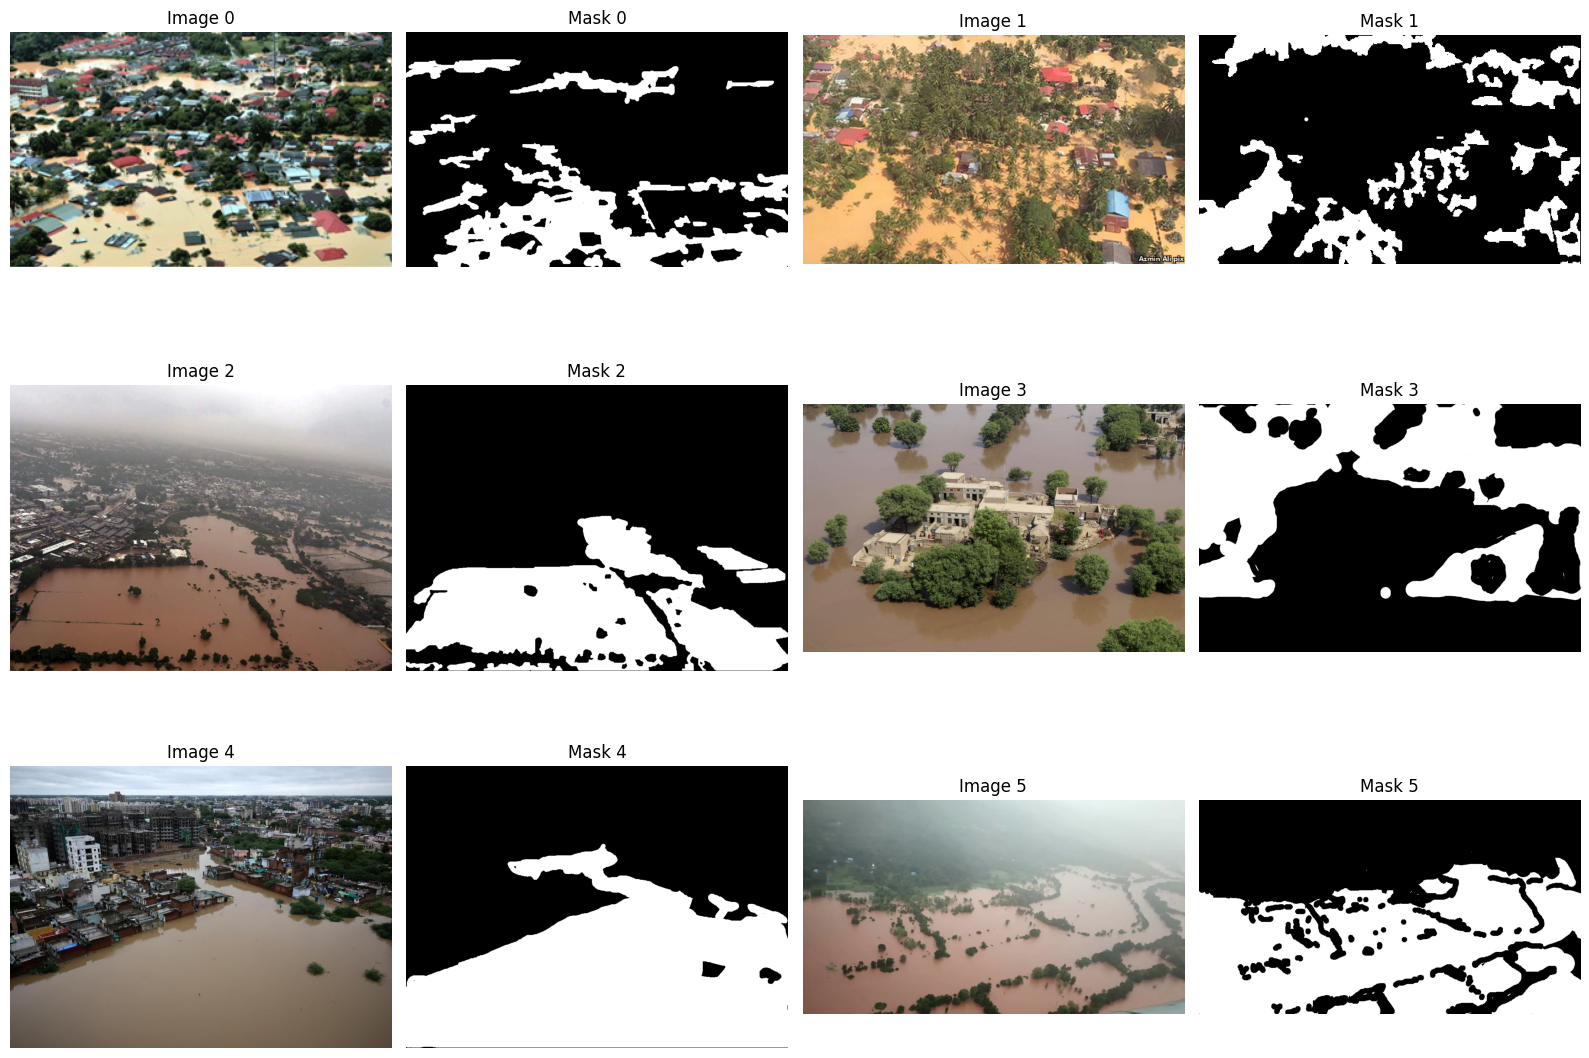

In [4]:
# ---- Paso 3: Carga y exploración de datos ----
def load_flood_data(dataset_path='flood_dataset', max_samples=100):
    """
    Cargar imágenes y máscaras del dataset de flood segmentation
    Estructura esperada:
    flood_dataset/
      ├── Image/ (.jpg)
      ├── Mask/  (.png)
      └── metadata.csv
    """
    image_dir = os.path.join(dataset_path, 'Image')  # COMPLETADO
    mask_dir  = os.path.join(dataset_path, 'Mask')   # COMPLETADO

    if not os.path.exists(image_dir):
        raise ValueError(f"❌ Directorio de imágenes no encontrado: {image_dir}")
    if not os.path.exists(mask_dir):
        raise ValueError(f"❌ Directorio de máscaras no encontrado: {mask_dir}")

    image_files = sorted([f for f in os.listdir(image_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:max_samples]

    images, masks = [], []
    print(f"📥 Cargando {len(image_files)} imágenes...")

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ No se pudo cargar: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        base_name = os.path.splitext(img_file)[0]
        mask_file = None
        for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
            potential_mask = base_name + ext
            mask_path = os.path.join(mask_dir, potential_mask)
            if os.path.exists(mask_path):
                mask_file = potential_mask
                break

        if mask_file is None:
            print(f"⚠️ Mask no encontrada para: {img_file}")
            continue

        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ No se pudo cargar mask: {mask_path}")
            continue

        mask = (mask > 127).astype(np.uint8)

        images.append(img)
        masks.append(mask)

        if (i + 1) % 20 == 0:
            print(f"  Cargadas {i + 1}/{len(image_files)}...")

    print(f"✅ Cargadas {len(images)} imágenes con sus máscaras")
    if len(images) == 0:
        raise ValueError("❌ No se cargaron imágenes. Verifica los paths.")
    return images, masks

images, masks = load_flood_data(dataset_path='flood_dataset', max_samples=100)

print(f"=== DATASET CARGADO ===")
print(f"Total images: {len(images)}")
print(f"Image shape (primera): {images[0].shape}")
print(f"Mask shape (primera): {masks[0].shape}")

# Estadísticas de tamaños y ratio de agua
image_sizes = [img.shape[:2] for img in images]
unique_sizes = set(image_sizes)
print("\n📊 Estadísticas del dataset:")
print(f"Tamaños únicos de imágenes: {len(unique_sizes)}")
if len(unique_sizes) <= 5:
    for size in unique_sizes:
        count = image_sizes.count(size)
        print(f"  {size}: {count} imágenes")

total_water_pixels = sum(mask.sum() for mask in masks)
total_pixels = sum(mask.size for mask in masks)
water_ratio = total_water_pixels / total_pixels
print(f"\nWater pixel ratio (promedio): {water_ratio:.2%}")
print(f"Background ratio: {(1 - water_ratio):.2%}")

# Visualización de muestras
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(6):
    axes[i // 2, (i % 2) * 2].imshow(images[i])
    axes[i // 2, (i % 2) * 2].set_title(f'Image {i}')
    axes[i // 2, (i % 2) * 2].axis('off')

    axes[i // 2, (i % 2) * 2 + 1].imshow(masks[i], cmap='gray')
    axes[i // 2, (i % 2) * 2 + 1].set_title(f'Mask {i}')
    axes[i // 2, (i % 2) * 2 + 1].axis('off')
plt.tight_layout()
plt.show()


In [5]:
# ================================
# Parte 2 — Pretrained SAM Inference (Zero-shot)
# ================================

# ---- 2.1 Cargar SAM ViT-B ----
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"  # COMPLETADO

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)  # COMPLETADO
sam.to(device)  # COMPLETADO

print(f"✅ SAM model cargado: {model_type}")
print(f"   Device: {device}")


✅ SAM model cargado: vit_b
   Device: cpu


In [6]:
# ---- 2.2 Crear SAM Predictor ----
predictor = SamPredictor(sam)  # COMPLETADO
predictor.model.to(device)
print("✅ SAM Predictor creado")


✅ SAM Predictor creado


=== POINT PROMPT PREDICTION ===
Point: (1, 369) | Confidence: 0.965


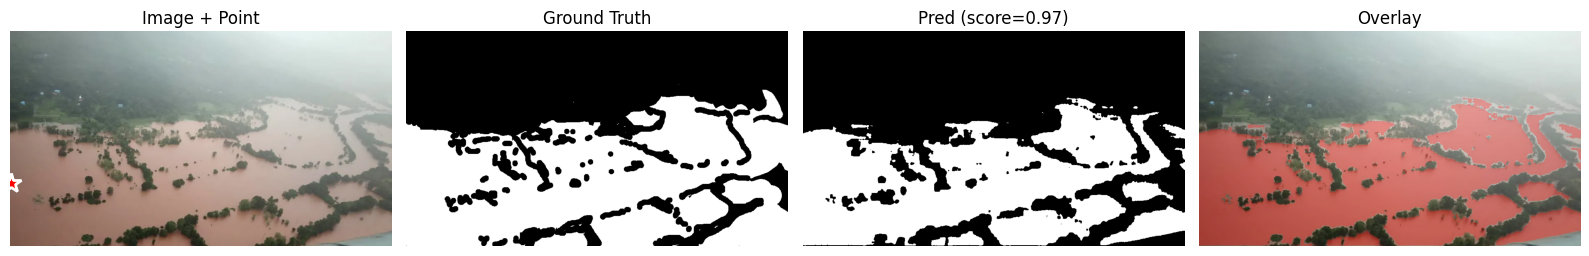

In [7]:
# ---- 2.3 Inference con Point Prompts ----
def predict_with_point_prompt(predictor, image, point_coords, point_labels):
    """
    Predict mask usando point prompts
    """
    predictor.set_image(image)  # COMPLETADO

    masks, scores, logits = predictor.predict(  # COMPLETADO
        point_coords=np.array(point_coords),     # COMPLETADO
        point_labels=np.array(point_labels),     # COMPLETADO
        multimask_output=True                    # COMPLETADO
    )

    best_mask_idx = np.argmax(scores)  # COMPLETADO
    best_mask = masks[best_mask_idx]   # COMPLETADO
    best_score = scores[best_mask_idx]

    if best_mask.shape != image.shape[:2]:
        best_mask = cv2.resize(
            best_mask.astype(np.uint8),
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)
    return best_mask, best_score

# Test rápido con una imagen
test_idx = 5 if len(images) > 5 else 0
test_image = images[test_idx]
test_mask_gt = masks[test_idx]

H, W = test_mask_gt.shape
ys, xs = np.where(test_mask_gt > 0)
if len(xs) > 0:
    point_x = int(xs[len(xs) // 2])
    point_y = int(ys[len(ys) // 2])
else:
    point_x, point_y = W // 2, H // 2

pred_mask, score = predict_with_point_prompt(predictor, test_image, [[point_x, point_y]], [1])
print(f"=== POINT PROMPT PREDICTION ===")
print(f"Point: ({point_x}, {point_y}) | Confidence: {score:.3f}")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(test_image); axes[0].plot(point_x, point_y, 'r*', ms=15, mec='white', mew=2)
axes[0].set_title('Image + Point'); axes[0].axis('off')
axes[1].imshow(test_mask_gt, cmap='gray'); axes[1].set_title('Ground Truth'); axes[1].axis('off')
axes[2].imshow(pred_mask, cmap='gray'); axes[2].set_title(f'Pred (score={score:.2f})'); axes[2].axis('off')
overlay = test_image.copy()
overlay[pred_mask > 0] = [255, 0, 0]
axes[3].imshow(cv2.addWeighted(test_image, 0.7, overlay, 0.3, 0))
axes[3].set_title('Overlay'); axes[3].axis('off')
plt.tight_layout(); plt.show()


=== BOX PROMPT PREDICTION ===
Box: [np.int64(0), np.int64(129), np.int64(928), np.int64(522)] | Confidence: 0.989


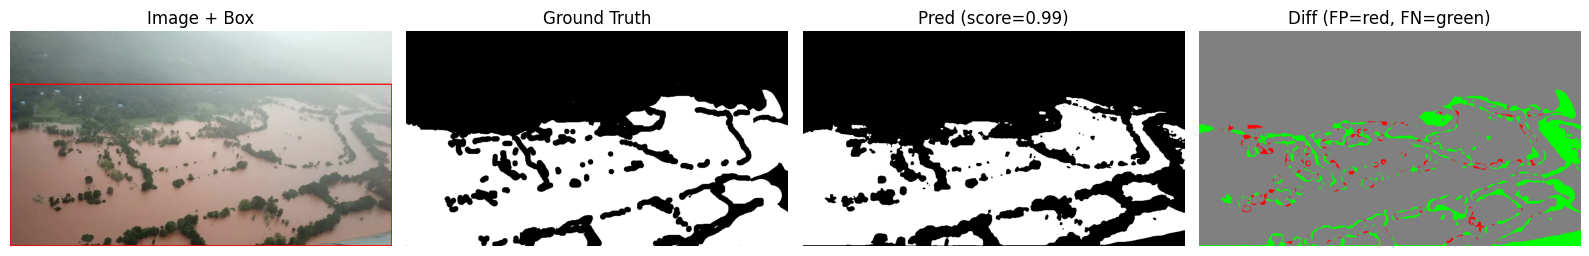

In [8]:
# ---- 2.4 Inference con Box Prompts ----
def predict_with_box_prompt(predictor, image, box):
    """
    Predict mask usando box prompt
    """
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        box=np.array(box),         # COMPLETADO
        multimask_output=False     # COMPLETADO
    )
    mask = masks[0]
    score = scores[0]

    if mask.shape != image.shape[:2]:
        mask = cv2.resize(
            mask.astype(np.uint8),
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST
        ).astype(bool)
    return mask, score

def get_bbox_from_mask(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if not rows.any() or not cols.any():
        return None
    y1, y2 = np.where(rows)[0][[0, -1]]
    x1, x2 = np.where(cols)[0][[0, -1]]
    return [x1, y1, x2, y2]

test_box = get_bbox_from_mask(test_mask_gt)
if test_box is not None:
    pred_mask_box, score_box = predict_with_box_prompt(predictor, test_image, test_box)
    print(f"=== BOX PROMPT PREDICTION ===")
    print(f"Box: {test_box} | Confidence: {score_box:.3f}")

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    img_box = test_image.copy()
    x1, y1, x2, y2 = test_box
    cv2.rectangle(img_box, (x1, y1), (x2, y2), (255, 0, 0), 2)
    axes[0].imshow(img_box); axes[0].set_title('Image + Box'); axes[0].axis('off')
    axes[1].imshow(test_mask_gt, cmap='gray'); axes[1].set_title('Ground Truth'); axes[1].axis('off')
    axes[2].imshow(pred_mask_box, cmap='gray'); axes[2].set_title(f'Pred (score={score_box:.2f})'); axes[2].axis('off')

    diff = (pred_mask_box.astype(int) - test_mask_gt.astype(int))
    diff_vis = np.zeros((*diff.shape, 3), dtype=np.uint8)
    diff_vis[diff > 0] = [255, 0, 0]   # FP
    diff_vis[diff < 0] = [0, 255, 0]   # FN
    diff_vis[diff == 0] = [128, 128, 128]
    axes[3].imshow(diff_vis); axes[3].set_title('Diff (FP=red, FN=green)'); axes[3].axis('off')
    plt.tight_layout(); plt.show()


In [9]:
# ---- 2.5 Métricas helpers ----
def calculate_iou(pred_mask, gt_mask):
    if pred_mask.shape != gt_mask.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8),
                               (gt_mask.shape[1], gt_mask.shape[0]),
                               interpolation=cv2.INTER_NEAREST).astype(bool)
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    inter = (pred_mask & gt_mask).sum()
    union = (pred_mask | gt_mask).sum()
    return inter / union if union > 0 else 0.0

def calculate_dice(pred_mask, gt_mask):
    if pred_mask.shape != gt_mask.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8),
                               (gt_mask.shape[1], gt_mask.shape[0]),
                               interpolation=cv2.INTER_NEAREST).astype(bool)
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    inter = (pred_mask & gt_mask).sum()
    denom = pred_mask.sum() + gt_mask.sum()
    return 1.0 if denom == 0 and inter == 0 else (2 * inter / denom)

def calculate_precision_recall(pred_mask, gt_mask):
    if pred_mask.shape != gt_mask.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8),
                               (gt_mask.shape[1], gt_mask.shape[0]),
                               interpolation=cv2.INTER_NEAREST).astype(bool)
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    tp = (pred_mask & gt_mask).sum()
    fp = (pred_mask & ~gt_mask).sum()
    fn = (~pred_mask & gt_mask).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return precision, recall

# Métricas por el ejemplo de point y box (si hay box)
iou_point = calculate_iou(pred_mask, test_mask_gt)
dice_point = calculate_dice(pred_mask, test_mask_gt)
prec_point, rec_point = calculate_precision_recall(pred_mask, test_mask_gt)

print(f"=== MÉTRICAS - POINT PROMPT ===")
print(f"IoU: {iou_point:.4f} | Dice: {dice_point:.4f} | Precision: {prec_point:.4f} | Recall: {rec_point:.4f}")

if test_box is not None:
    iou_box = calculate_iou(pred_mask_box, test_mask_gt)
    dice_box = calculate_dice(pred_mask_box, test_mask_gt)
    prec_box, rec_box = calculate_precision_recall(pred_mask_box, test_mask_gt)
    print(f"\n=== MÉTRICAS - BOX PROMPT ===")
    print(f"IoU: {iou_box:.4f} | Dice: {dice_box:.4f} | Precision: {prec_box:.4f} | Recall: {rec_box:.4f}")
    print(f"\n=== COMPARACIÓN ===")
    print(f"Box prompt better (IoU)?: {iou_box > iou_point}")


=== MÉTRICAS - POINT PROMPT ===
IoU: 0.8070 | Dice: 0.8932 | Precision: 0.9681 | Recall: 0.8290

=== MÉTRICAS - BOX PROMPT ===
IoU: 0.8016 | Dice: 0.8899 | Precision: 0.9756 | Recall: 0.8180

=== COMPARACIÓN ===
Box prompt better (IoU)?: False


=== EVALUATING PRETRAINED SAM (Point Prompts) ===
  Processed 20/100 images...
  Processed 40/100 images...
  Processed 60/100 images...
  Processed 80/100 images...
  Processed 100/100 images...

=== PRETRAINED SAM - POINT PROMPTS ===
Mean IoU: 0.5291 ± 0.3214
Mean Dice: 0.6220 ± 0.3377
Mean Precision: 0.8193
Mean Recall: 0.5885

=== EVALUATING PRETRAINED SAM (Box Prompts) ===
  Processed 20/100 images...
  Processed 40/100 images...
  Processed 60/100 images...
  Processed 80/100 images...
  Processed 100/100 images...

=== PRETRAINED SAM - BOX PROMPTS ===
Mean IoU: 0.7230 ± 0.2088
Mean Dice: 0.8156 ± 0.1985
Mean Precision: 0.8476
Mean Recall: 0.8106


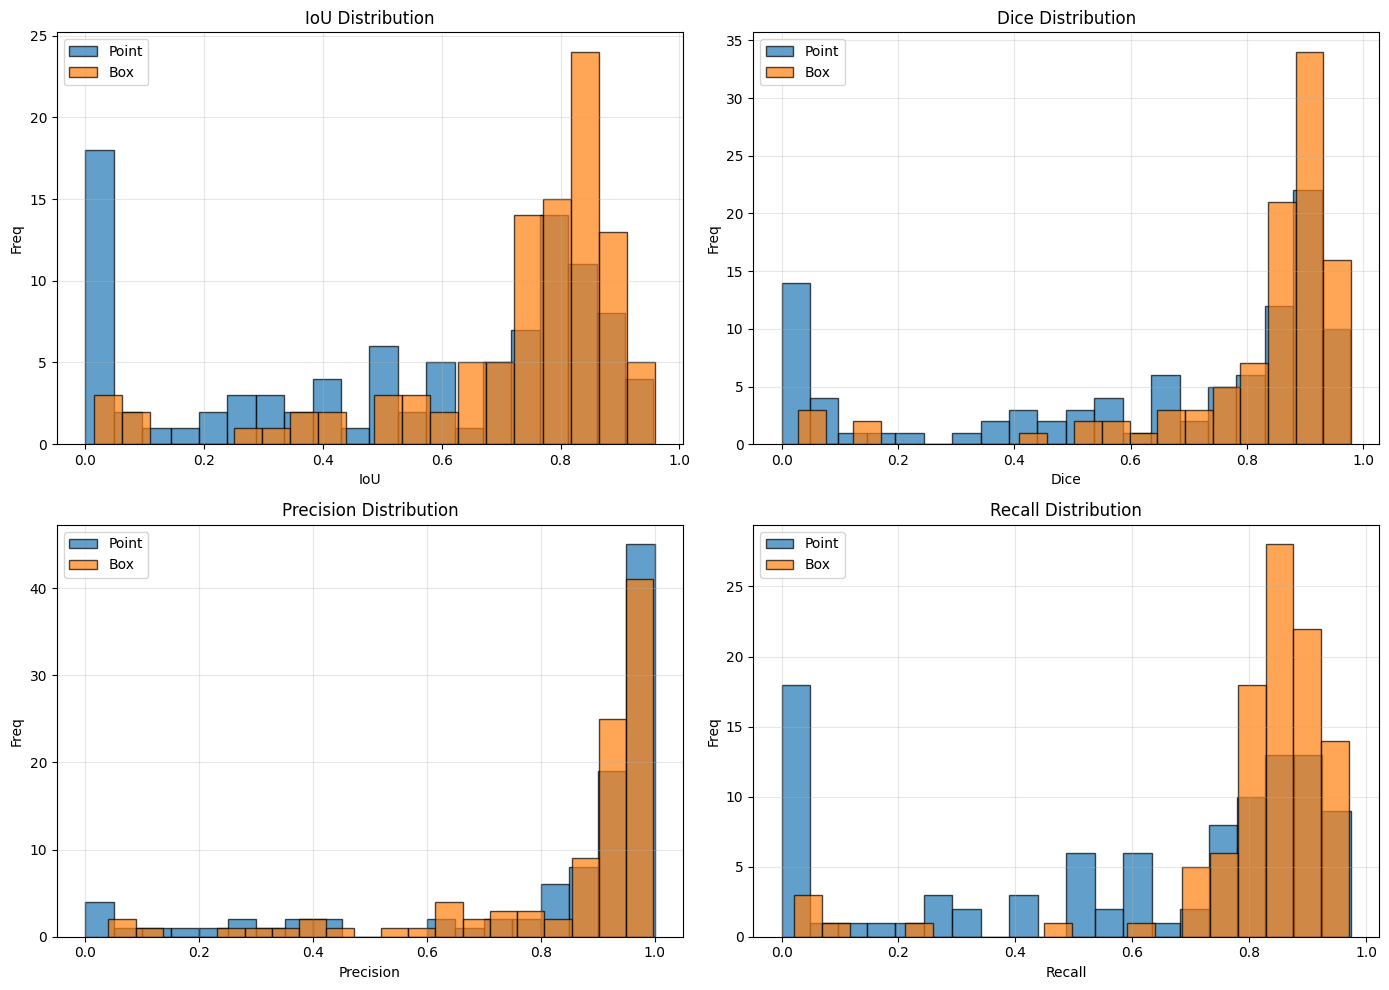

In [10]:
# ---- 2.6 Evaluación en el set completo (pretrained) ----
def evaluate_pretrained_sam(images, masks, predictor, prompt_type='point'):
    results = {'iou': [], 'dice': [], 'precision': [], 'recall': []}
    for i, (image, mask_gt) in enumerate(zip(images, masks)):
        if prompt_type == 'point':
            y_coords, x_coords = np.where(mask_gt > 0)
            if len(x_coords) == 0:
                continue
            point_x = int(x_coords[len(x_coords) // 2])
            point_y = int(y_coords[len(y_coords) // 2])
            pred_mask, _ = predict_with_point_prompt(predictor, image, [[point_x, point_y]], [1])
        elif prompt_type == 'box':
            box = get_bbox_from_mask(mask_gt)
            if box is None:
                continue
            pred_mask, _ = predict_with_box_prompt(predictor, image, box)
        else:
            raise ValueError("prompt_type must be 'point' or 'box'")

        iou = calculate_iou(pred_mask, mask_gt)
        dice = calculate_dice(pred_mask, mask_gt)
        prec, rec = calculate_precision_recall(pred_mask, mask_gt)

        results['iou'].append(iou)
        results['dice'].append(dice)
        results['precision'].append(prec)
        results['recall'].append(rec)

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1}/{len(images)} images...")

    for key in results:
        results[key] = np.array(results[key])
    return results

print("=== EVALUATING PRETRAINED SAM (Point Prompts) ===")
results_pretrained_point = evaluate_pretrained_sam(images, masks, predictor, prompt_type='point')
print(f"\n=== PRETRAINED SAM - POINT PROMPTS ===")
print(f"Mean IoU: {results_pretrained_point['iou'].mean():.4f} ± {results_pretrained_point['iou'].std():.4f}")
print(f"Mean Dice: {results_pretrained_point['dice'].mean():.4f} ± {results_pretrained_point['dice'].std():.4f}")
print(f"Mean Precision: {results_pretrained_point['precision'].mean():.4f}")
print(f"Mean Recall: {results_pretrained_point['recall'].mean():.4f}")

print("\n=== EVALUATING PRETRAINED SAM (Box Prompts) ===")
results_pretrained_box = evaluate_pretrained_sam(images, masks, predictor, prompt_type='box')
print(f"\n=== PRETRAINED SAM - BOX PROMPTS ===")
print(f"Mean IoU: {results_pretrained_box['iou'].mean():.4f} ± {results_pretrained_box['iou'].std():.4f}")
print(f"Mean Dice: {results_pretrained_box['dice'].mean():.4f} ± {results_pretrained_box['dice'].std():.4f}")
print(f"Mean Precision: {results_pretrained_box['precision'].mean():.4f}")
print(f"Mean Recall: {results_pretrained_box['recall'].mean():.4f}")

# Histogramas comparativos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].hist(results_pretrained_point['iou'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[0, 0].hist(results_pretrained_box['iou'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[0, 0].set_xlabel('IoU'); axes[0, 0].set_ylabel('Freq'); axes[0, 0].set_title('IoU Distribution'); axes[0, 0].legend(); axes[0, 0].grid(alpha=0.3)
axes[0, 1].hist(results_pretrained_point['dice'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[0, 1].hist(results_pretrained_box['dice'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[0, 1].set_xlabel('Dice'); axes[0, 1].set_ylabel('Freq'); axes[0, 1].set_title('Dice Distribution'); axes[0, 1].legend(); axes[0, 1].grid(alpha=0.3)
axes[1, 0].hist(results_pretrained_point['precision'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[1, 0].hist(results_pretrained_box['precision'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[1, 0].set_xlabel('Precision'); axes[1, 0].set_ylabel('Freq'); axes[1, 0].set_title('Precision Distribution'); axes[1, 0].legend(); axes[1, 0].grid(alpha=0.3)
axes[1, 1].hist(results_pretrained_point['recall'], bins=20, alpha=0.7, label='Point', edgecolor='black')
axes[1, 1].hist(results_pretrained_box['recall'], bins=20, alpha=0.7, label='Box', edgecolor='black')
axes[1, 1].set_xlabel('Recall'); axes[1, 1].set_ylabel('Freq'); axes[1, 1].set_title('Recall Distribution'); axes[1, 1].legend(); axes[1, 1].grid(alpha=0.3)
plt.tight_layout(); plt.show()


In [11]:
# ================================
# Parte 3 — Fine-tuning SAM (entrenar solo Mask Decoder)
# ================================

class FloodSegmentationDataset(Dataset):
    """
    Dataset para flood segmentation
    Redimensiona todo a 1024x1024 (tamaño nativo SAM).
    """
    def __init__(self, images, masks, transform=None, prompt_type='point', image_size=1024):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.prompt_type = prompt_type
        self.image_size = image_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].copy()
        mask = self.masks[idx].copy()

        original_size = image.shape[:2]
        image_resized = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask_resized  = cv2.resize(mask,  (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=image_resized, mask=mask_resized)  # COMPLETADO
            image_resized = augmented['image']  # COMPLETADO
            mask_resized  = augmented['mask']   # COMPLETADO

        image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).to(torch.float32) / 255.0  # COMPLETADO
        mask_tensor  = torch.from_numpy(mask_resized).unsqueeze(0).float()

        if self.prompt_type == 'point':
            y_coords, x_coords = np.where(mask_resized > 0)
            if len(x_coords) > 0:
                rand_idx = np.random.randint(len(x_coords))
                point = np.array([[x_coords[rand_idx], y_coords[rand_idx]]])
                label = np.array([1])
            else:
                point = np.array([[self.image_size // 2, self.image_size // 2]])
                label = np.array([0])
            prompt = {'points': point, 'labels': label, 'boxes': None}
        else:
            box = get_bbox_from_mask(mask_resized)
            if box is None:
                box = [0, 0, self.image_size, self.image_size]
            prompt = {'points': None, 'labels': None, 'boxes': np.array([box])}

        return {
            'image': image_tensor,
            'mask': mask_tensor,
            'original_size': original_size,
            'prompt': prompt
        }

# Split 80/20
train_size = int(0.8 * len(images))
train_images, val_images = images[:train_size], images[train_size:]
train_masks,  val_masks  = masks[:train_size],  masks[train_size:]

print(f"=== DATA SPLIT ===")
print(f"Train: {len(train_images)} | Val: {len(val_images)}")

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
])

train_dataset = FloodSegmentationDataset(train_images, train_masks, transform=train_transform, prompt_type='point')
val_dataset   = FloodSegmentationDataset(val_images,   val_masks,   transform=None,        prompt_type='point')
print("✅ Datasets creados")


=== DATA SPLIT ===
Train: 80 | Val: 20
✅ Datasets creados


In [12]:
# ---- 3.2 DataLoader ----
def collate_fn(batch):
    return {
        'images': torch.stack([item['image'] for item in batch]),
        'masks': torch.stack([item['mask'] for item in batch]),
        'prompts': [item['prompt'] for item in batch],
        'original_sizes': [item['original_size'] for item in batch]
    }

batch_size = 2          # COMPLETADO (ajustar si GPU chica)
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,  # COMPLETADO
    shuffle=True,           # COMPLETADO
    num_workers=num_workers,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,          # COMPLETADO
    num_workers=num_workers,
    collate_fn=collate_fn
)

print(f"=== DATALOADERS CREADOS ===")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")
sample_batch = next(iter(train_loader))
print(f"Sample batch -> Images: {sample_batch['images'].shape} | Masks: {sample_batch['masks'].shape} | Prompts: {len(sample_batch['prompts'])}")


=== DATALOADERS CREADOS ===
Train batches: 40 | Val batches: 10
Sample batch -> Images: torch.Size([2, 3, 1024, 1024]) | Masks: torch.Size([2, 1, 1024, 1024]) | Prompts: 2


In [13]:
# ---- 3.3 Loss Functions ----
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)  # COMPLETADO
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()  # COMPLETADO
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    return 1 - dice

def combined_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='mean')
    dsc = dice_loss(pred, target)
    return bce_weight * bce + (1 - bce_weight) * dsc

print("✅ Loss functions definidas")
test_pred = torch.randn(2, 1, 256, 256)
test_target = torch.randint(0, 2, (2, 1, 256, 256)).float()
print(f"Test loss: {combined_loss(test_pred, test_target).item():.4f}")


✅ Loss functions definidas
Test loss: 0.6532


In [14]:
# ---- 3.4 Fine-tuning Setup ----
sam_finetune = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_finetune.to(device)

# Freeze image encoder
for param in sam_finetune.image_encoder.parameters():  # COMPLETADO
    param.requires_grad = False                        # COMPLETADO

# Train solo mask decoder
for param in sam_finetune.mask_decoder.parameters():   # COMPLETADO
    param.requires_grad = True                         # COMPLETADO

# Freeze prompt encoder también
for param in sam_finetune.prompt_encoder.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in sam_finetune.parameters())
trainable_params = sum(p.numel() for p in sam_finetune.parameters() if p.requires_grad)
print(f"=== FINE-TUNING SETUP ===")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100 * trainable_params / total_params:.2f}%)")

learning_rate = 1e-4  # COMPLETADO
optimizer = torch.optim.Adam(                      # COMPLETADO
    [p for p in sam_finetune.parameters() if p.requires_grad],
    lr=learning_rate                               # COMPLETADO
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
print("Optimizer: Adam | LR:", learning_rate)


=== FINE-TUNING SETUP ===
Total parameters: 93,735,472
Trainable parameters: 4,058,340 (4.33%)
Optimizer: Adam | LR: 0.0001


In [15]:
# ---- 3.5 Funciones de training/validation ----
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    n_batches = 0

    for batch in dataloader:
        images = batch['images'].to(device)
        masks_gt = batch['masks'].to(device)
        prompts = batch['prompts']

        batch_size_actual = images.shape[0]
        for i in range(batch_size_actual):
            image = images[i:i+1]
            mask = masks_gt[i:i+1]
            prompt = prompts[i]

            with torch.no_grad():
                image_embedding = model.image_encoder(image)  # COMPLETADO

            if prompt['points'] is not None:
                points = (
                    torch.from_numpy(prompt['points']).float().unsqueeze(0).to(device),
                    torch.from_numpy(prompt['labels']).float().unsqueeze(0).to(device)
                )
                sparse_emb, dense_emb = model.prompt_encoder(points=points, boxes=None, masks=None)
            else:
                boxes = torch.from_numpy(prompt['boxes']).float().unsqueeze(0).to(device)
                sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=boxes, masks=None)

            mask_pred, iou_pred = model.mask_decoder(         # COMPLETADO
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_emb,
                dense_prompt_embeddings=dense_emb,
                multimask_output=False
            )

            mask_resized = F.interpolate(mask, size=(256, 256), mode='bilinear', align_corners=False)
            loss = loss_fn(mask_pred, mask_resized)

            optimizer.zero_grad()
            loss.backward()        # COMPLETADO
            optimizer.step()       # COMPLETADO

            with torch.no_grad():
                pred_binary = (torch.sigmoid(mask_pred) > 0.5).float()
                pred_binary_full = F.interpolate(pred_binary, size=(1024, 1024), mode='nearest')
                iou = calculate_iou(
                    pred_binary_full.cpu().numpy()[0, 0],
                    mask.cpu().numpy()[0, 0]
                )

            epoch_loss += loss.item()
            epoch_iou += iou
            n_batches += 1

    return epoch_loss / n_batches, epoch_iou / n_batches

def validate(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch['images'].to(device)
            masks_gt = batch['masks'].to(device)
            prompts = batch['prompts']

            batch_size_actual = images.shape[0]
            for i in range(batch_size_actual):
                image = images[i:i+1]
                mask = masks_gt[i:i+1]
                prompt = prompts[i]

                image_embedding = model.image_encoder(image)

                if prompt['points'] is not None:
                    points = (
                        torch.from_numpy(prompt['points']).float().unsqueeze(0).to(device),
                        torch.from_numpy(prompt['labels']).float().unsqueeze(0).to(device)
                    )
                    sparse_emb, dense_emb = model.prompt_encoder(points=points, boxes=None, masks=None)
                else:
                    boxes = torch.from_numpy(prompt['boxes']).float().unsqueeze(0).to(device)
                    sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=boxes, masks=None)

                mask_pred, _ = model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_emb,
                    dense_prompt_embeddings=dense_emb,
                    multimask_output=False
                )

                mask_resized = F.interpolate(mask, size=(256, 256), mode='bilinear', align_corners=False)
                loss = loss_fn(mask_pred, mask_resized)

                pred_binary = (torch.sigmoid(mask_pred) > 0.5).float()
                pred_binary_full = F.interpolate(pred_binary, size=(1024, 1024), mode='nearest')
                iou = calculate_iou(
                    pred_binary_full.cpu().numpy()[0, 0],
                    mask.cpu().numpy()[0, 0]
                )

                val_loss += loss.item()
                val_iou += iou
                n_batches += 1

    return val_loss / n_batches, val_iou / n_batches

print("✅ Training functions definidas")


✅ Training functions definidas


=== STARTING TRAINING ===
Epochs: 1 | Batch size: 2 | LR: 0.0001

Epoch 1/1
--------------------------------------------------
Train Loss: 0.4126 | Train IoU: 0.5888
Val   Loss: 0.3475 | Val   IoU: 0.6244
✅ Best model saved! (Val IoU: 0.6244)

=== TRAINING COMPLETED ===
Best Val IoU: 0.6244


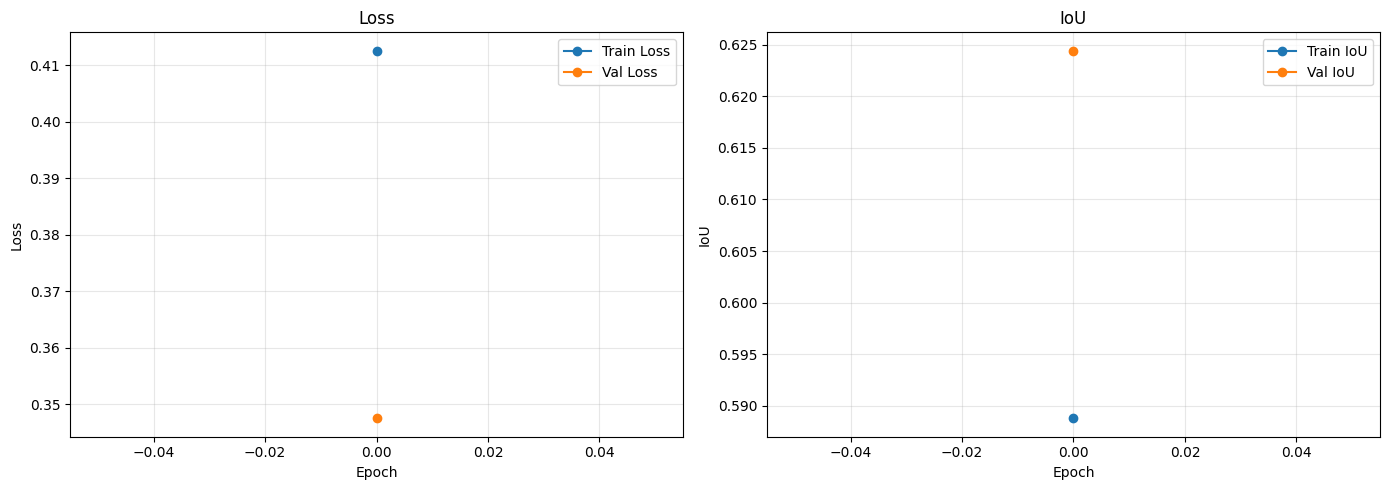

In [17]:
# ---- 3.6 Entrenamiento ----
num_epochs = 1   # COMPLETADO (ajustar según tiempo/GPU)
best_val_iou = 0.0
history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

print("=== STARTING TRAINING ===")
print(f"Epochs: {num_epochs} | Batch size: {batch_size} | LR: {learning_rate}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)
    train_loss, train_iou = train_epoch(sam_finetune, train_loader, optimizer, combined_loss, device)
    val_loss, val_iou = validate(sam_finetune, val_loader, combined_loss, device)
    scheduler.step()

    history['train_loss'].append(train_loss); history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss);     history['val_iou'].append(val_iou)

    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   IoU: {val_iou:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(sam_finetune.state_dict(), 'sam_finetuned_best.pth')
        print(f"✅ Best model saved! (Val IoU: {best_val_iou:.4f})")

print("\n=== TRAINING COMPLETED ===")
print(f"Best Val IoU: {best_val_iou:.4f}")

# Curvas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(history['train_iou'], label='Train IoU', marker='o')
axes[1].plot(history['val_iou'], label='Val IoU', marker='o')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('IoU'); axes[1].set_title('IoU'); axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()


✅ Fine-tuned model cargado
=== EVALUATING FINE-TUNED SAM (Val set, point prompts) ===
  Processed 20/20 images...

=== FINE-TUNED SAM ===
Mean IoU: 0.6253 ± 0.2736
Mean Dice: 0.7247 ± 0.2696
Mean Precision: 0.8972
Mean Recall: 0.6582

=== COMPARISON (Pretrained Point vs Fine-tuned) ===
Metric       Pretrained   Fine-tuned   Improvement 
------------------------------------------------------
IOU          0.5291       0.6253       18.18      %
DICE         0.6220       0.7247       16.51      %
PRECISION    0.8193       0.8972       9.52       %
RECALL       0.5885       0.6582       11.83      %


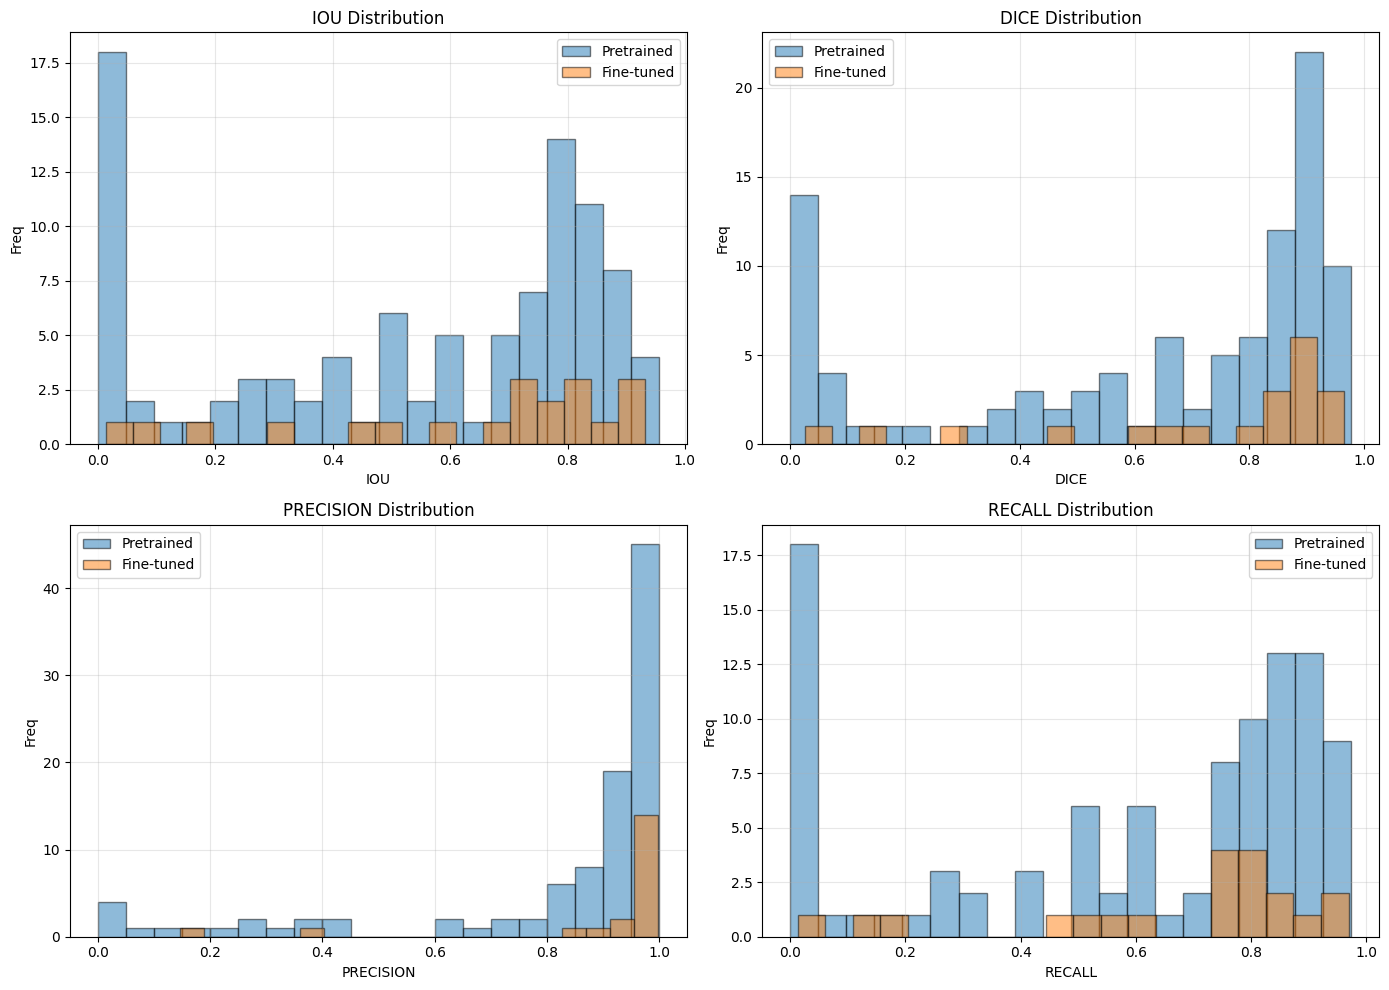

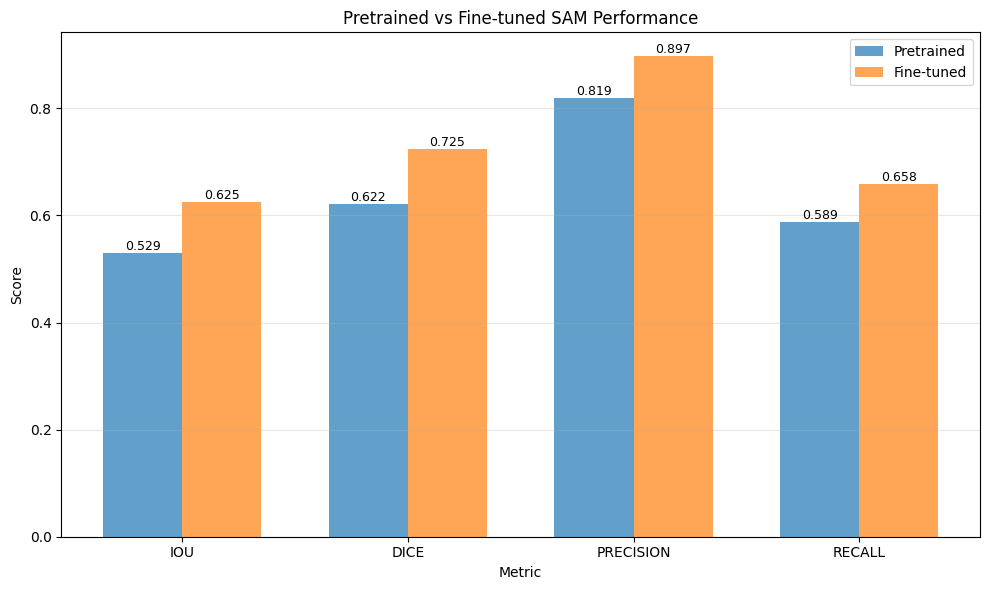

In [18]:
# ================================
# Parte 4 — Evaluación y Comparación
# ================================

# ---- 4.1 Cargar best model y crear predictor ----
sam_finetuned = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_finetuned.load_state_dict(torch.load('sam_finetuned_best.pth', map_location=device))
sam_finetuned.to(device)
sam_finetuned.eval()
print("✅ Fine-tuned model cargado")

predictor_finetuned = SamPredictor(sam_finetuned)

# ---- 4.2 Evaluación fine-tuned vs pretrained ----
print("=== EVALUATING FINE-TUNED SAM (Val set, point prompts) ===")
results_finetuned = evaluate_pretrained_sam(val_images, val_masks, predictor_finetuned, prompt_type='point')

print(f"\n=== FINE-TUNED SAM ===")
print(f"Mean IoU: {results_finetuned['iou'].mean():.4f} ± {results_finetuned['iou'].std():.4f}")
print(f"Mean Dice: {results_finetuned['dice'].mean():.4f} ± {results_finetuned['dice'].std():.4f}")
print(f"Mean Precision: {results_finetuned['precision'].mean():.4f}")
print(f"Mean Recall: {results_finetuned['recall'].mean():.4f}")

print("\n=== COMPARISON (Pretrained Point vs Fine-tuned) ===")
metrics = ['iou', 'dice', 'precision', 'recall']
print(f"{'Metric':<12} {'Pretrained':<12} {'Fine-tuned':<12} {'Improvement':<12}")
print("-" * 54)
for m in metrics:
    pre = results_pretrained_point[m].mean()
    ft  = results_finetuned[m].mean()
    imp = ((ft - pre) / pre * 100) if pre > 0 else float('inf')
    print(f"{m.upper():<12} {pre:<12.4f} {ft:<12.4f} {imp:<11.2f}%")

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, m in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    ax.hist(results_pretrained_point[m], bins=20, alpha=0.5, label='Pretrained', edgecolor='black')
    ax.hist(results_finetuned[m],        bins=20, alpha=0.5, label='Fine-tuned', edgecolor='black')
    ax.set_xlabel(m.upper()); ax.set_ylabel('Freq'); ax.set_title(f'{m.upper()} Distribution'); ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics)); width = 0.35
pre_means = [results_pretrained_point[m].mean() for m in metrics]
ft_means  = [results_finetuned[m].mean() for m in metrics]
bars1 = ax.bar(x - width/2, pre_means, width, label='Pretrained', alpha=0.7)
bars2 = ax.bar(x + width/2, ft_means,  width, label='Fine-tuned', alpha=0.7)
ax.set_xlabel('Metric'); ax.set_ylabel('Score'); ax.set_title('Pretrained vs Fine-tuned SAM Performance')
ax.set_xticks(x); ax.set_xticklabels([m.upper() for m in metrics]); ax.legend(); ax.grid(alpha=0.3, axis='y')
for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2., h, f'{h:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout(); plt.show()


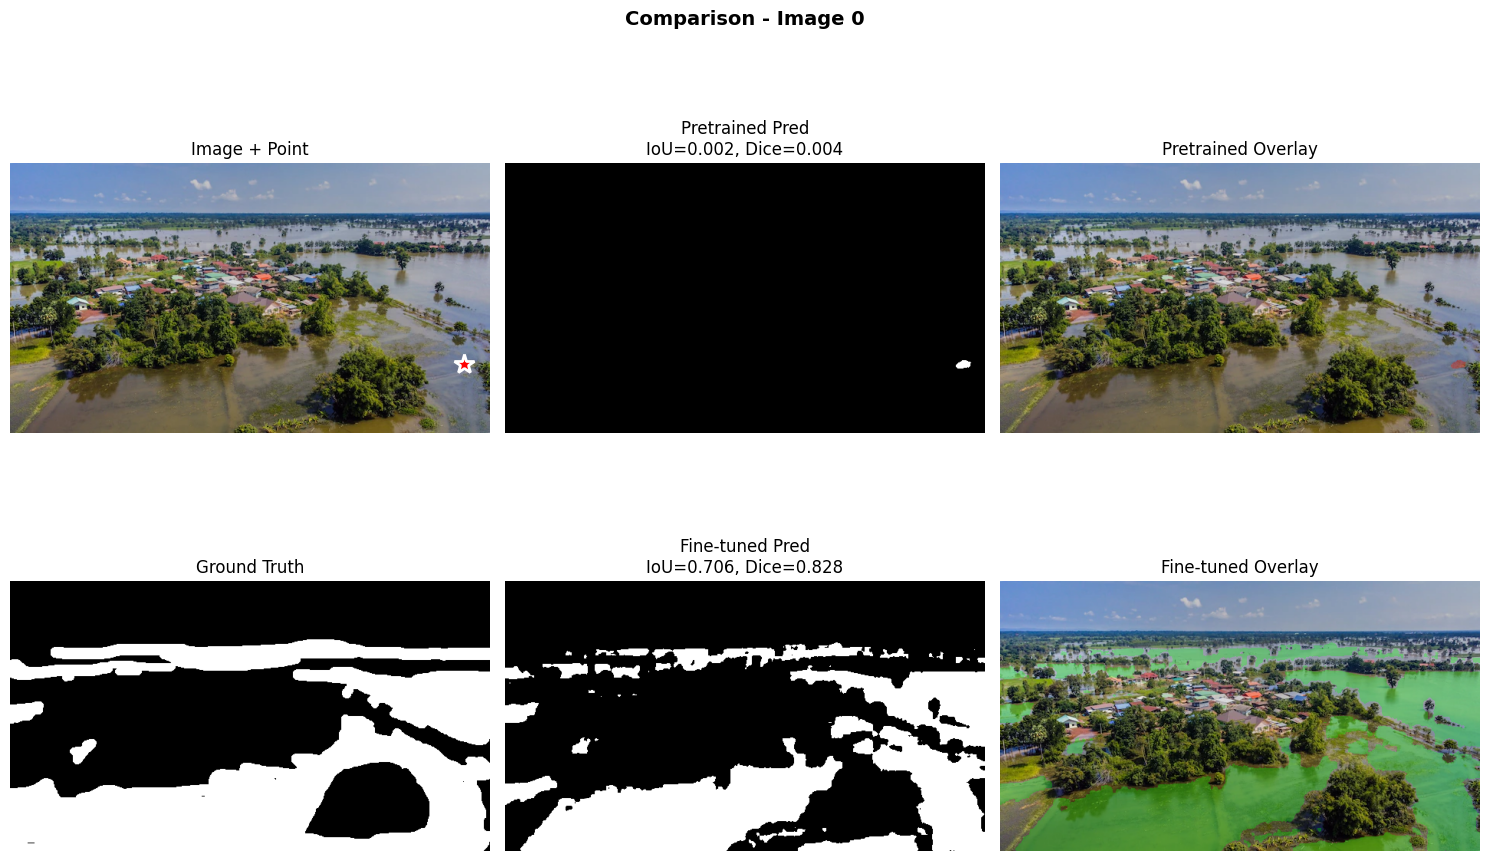

=== IMAGE 0 ===
Pretrained: IoU=0.0018, Dice=0.0036
Fine-tuned: IoU=0.7062, Dice=0.8278
Improvement: IoU +0.7044, Dice +0.8242



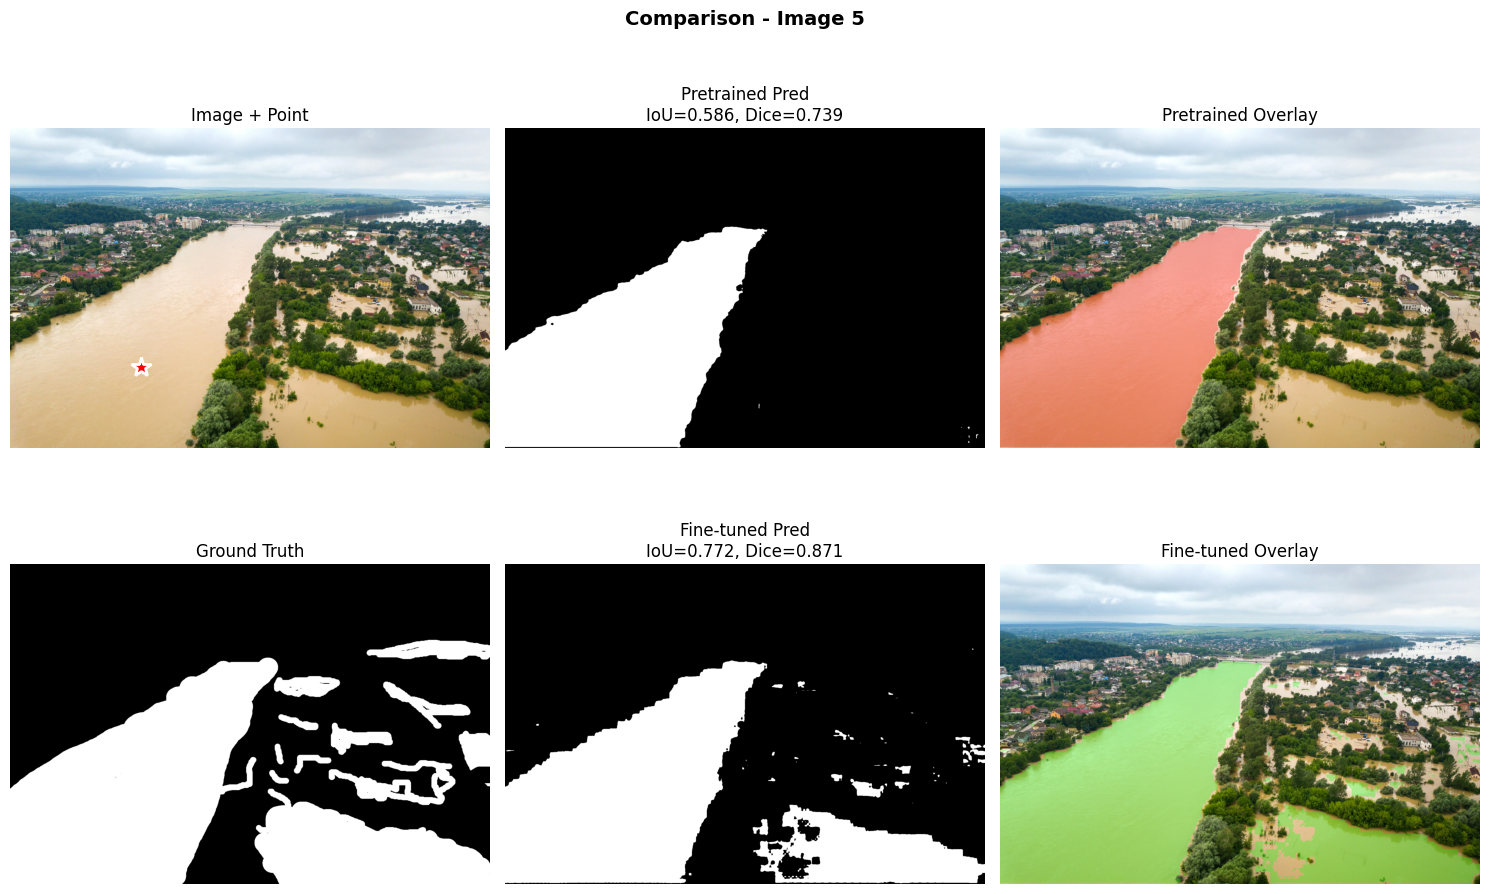

=== IMAGE 5 ===
Pretrained: IoU=0.5862, Dice=0.7391
Fine-tuned: IoU=0.7716, Dice=0.8711
Improvement: IoU +0.1854, Dice +0.1319



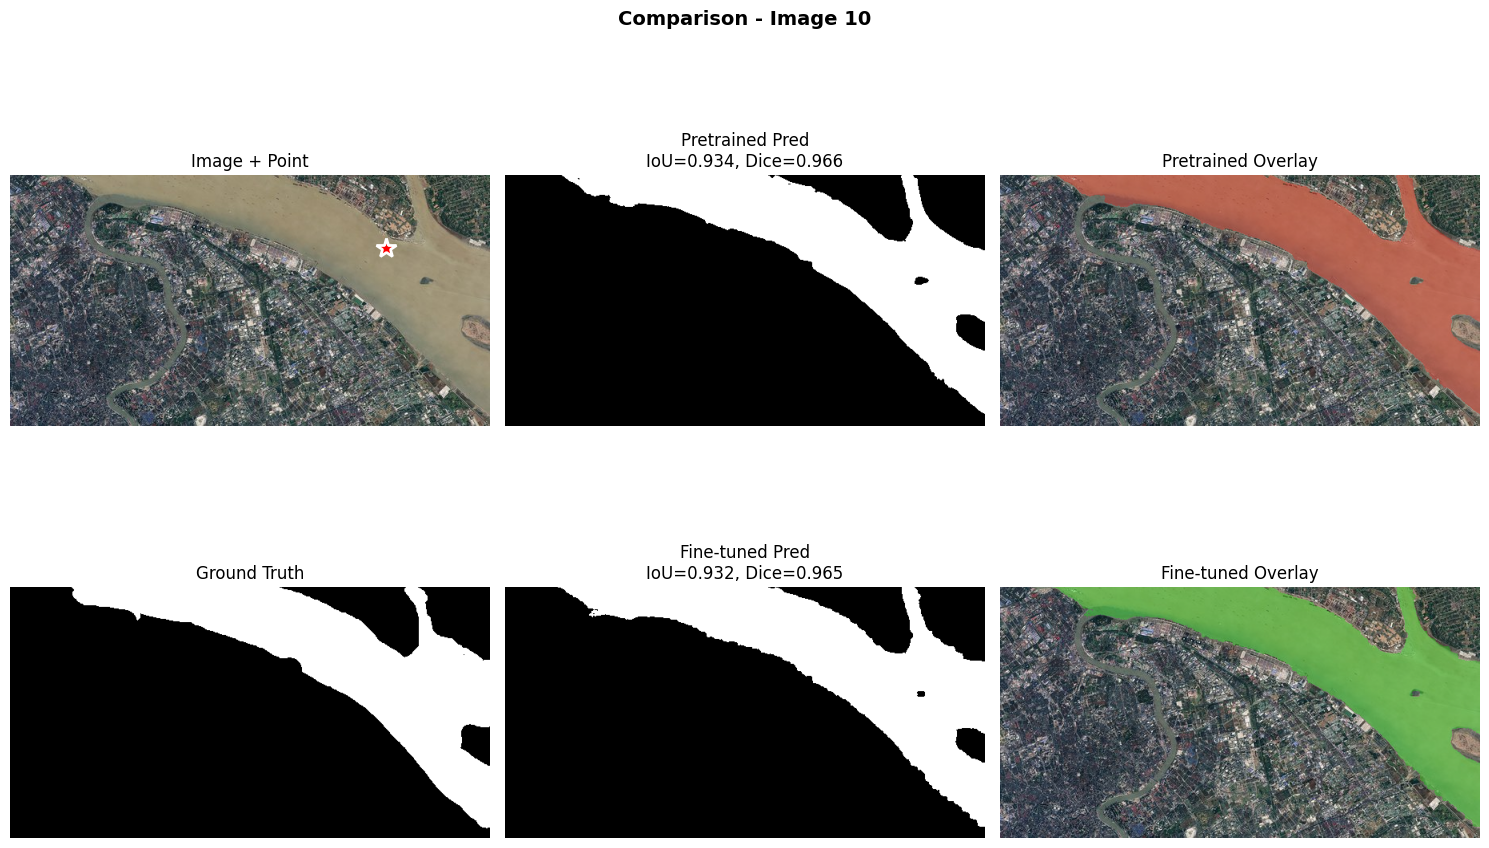

=== IMAGE 10 ===
Pretrained: IoU=0.9338, Dice=0.9658
Fine-tuned: IoU=0.9316, Dice=0.9646
Improvement: IoU +-0.0022, Dice +-0.0012



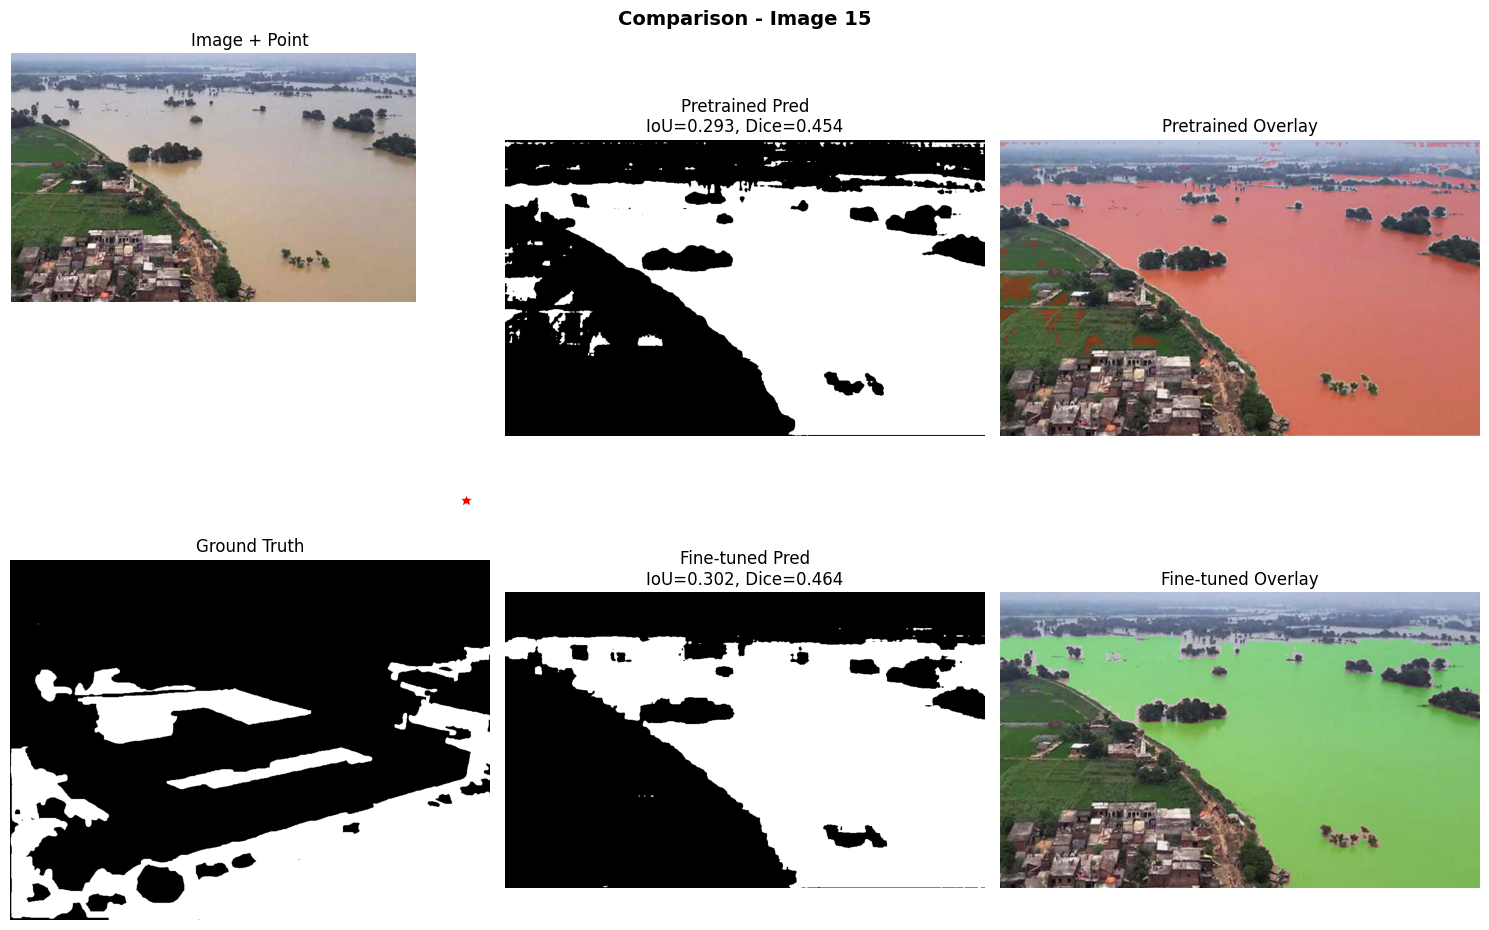

=== IMAGE 15 ===
Pretrained: IoU=0.2934, Dice=0.4537
Fine-tuned: IoU=0.3020, Dice=0.4639
Improvement: IoU +0.0086, Dice +0.0102



In [19]:
# ---- 4.3 Visualización cualitativa ----
def visualize_comparison(idx, images, masks, predictor_pre, predictor_ft):
    image = images[idx]; mask_gt = masks[idx]
    ys, xs = np.where(mask_gt > 0)
    if len(xs) > 0:
        point_x = int(xs[len(xs) // 2]); point_y = int(ys[len(ys) // 2])
    else:
        point_x, point_y = mask_gt.shape[1] // 2, mask_gt.shape[0] // 2

    pred_pre, _ = predict_with_point_prompt(predictor_pre, image, [[point_x, point_y]], [1])
    pred_ft,  _ = predict_with_point_prompt(predictor_ft,  image, [[point_x, point_y]], [1])

    iou_pre  = calculate_iou(pred_pre, mask_gt);  dice_pre = calculate_dice(pred_pre, mask_gt)
    iou_ft   = calculate_iou(pred_ft,  mask_gt);  dice_ft  = calculate_dice(pred_ft,  mask_gt)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes[0, 0].imshow(image); axes[0, 0].plot(point_x, point_y, 'r*', ms=15, mec='white', mew=2)
    axes[0, 0].set_title('Image + Point'); axes[0, 0].axis('off')
    axes[0, 1].imshow(pred_pre, cmap='gray'); axes[0, 1].set_title(f'Pretrained Pred\nIoU={iou_pre:.3f}, Dice={dice_pre:.3f}'); axes[0, 1].axis('off')
    overlay_pre = image.copy(); overlay_pre[pred_pre > 0] = [255, 0, 0]
    axes[0, 2].imshow(cv2.addWeighted(image, 0.7, overlay_pre, 0.3, 0)); axes[0, 2].set_title('Pretrained Overlay'); axes[0, 2].axis('off')
    axes[1, 0].imshow(mask_gt, cmap='gray'); axes[1, 0].set_title('Ground Truth'); axes[1, 0].axis('off')
    axes[1, 1].imshow(pred_ft, cmap='gray'); axes[1, 1].set_title(f'Fine-tuned Pred\nIoU={iou_ft:.3f}, Dice={dice_ft:.3f}'); axes[1, 1].axis('off')
    overlay_ft = image.copy(); overlay_ft[pred_ft > 0] = [0, 255, 0]
    axes[1, 2].imshow(cv2.addWeighted(image, 0.7, overlay_ft, 0.3, 0)); axes[1, 2].set_title('Fine-tuned Overlay'); axes[1, 2].axis('off')
    plt.suptitle(f'Comparison - Image {idx}', fontsize=14, fontweight='bold'); plt.tight_layout(); plt.show()
    print(f"=== IMAGE {idx} ===")
    print(f"Pretrained: IoU={iou_pre:.4f}, Dice={dice_pre:.4f}")
    print(f"Fine-tuned: IoU={iou_ft:.4f}, Dice={dice_ft:.4f}")
    print(f"Improvement: IoU +{(iou_ft - iou_pre):.4f}, Dice +{(dice_ft - dice_pre):.4f}")

for idx in [0, 5, 10, 15, 20]:
    if idx < len(val_images):
        visualize_comparison(idx, val_images, val_masks, predictor, predictor_finetuned)
        print()


=== ANALYZING PRETRAINED FAILURES ===
Failure cases: 7

Failure statistics:
  Mean IoU: 0.092
  Mean water region width: 1.00 px


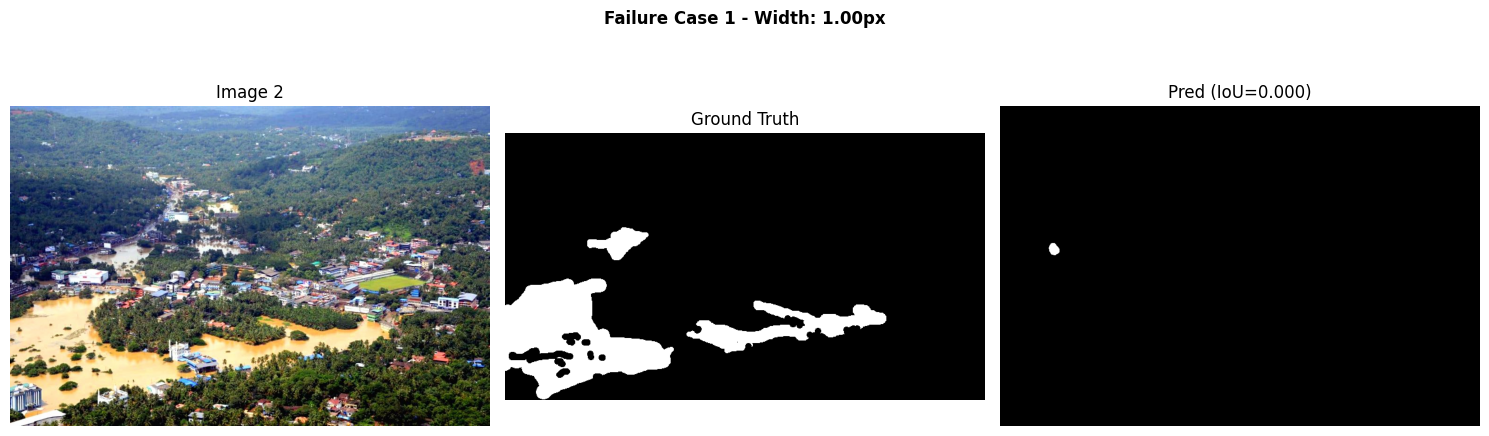

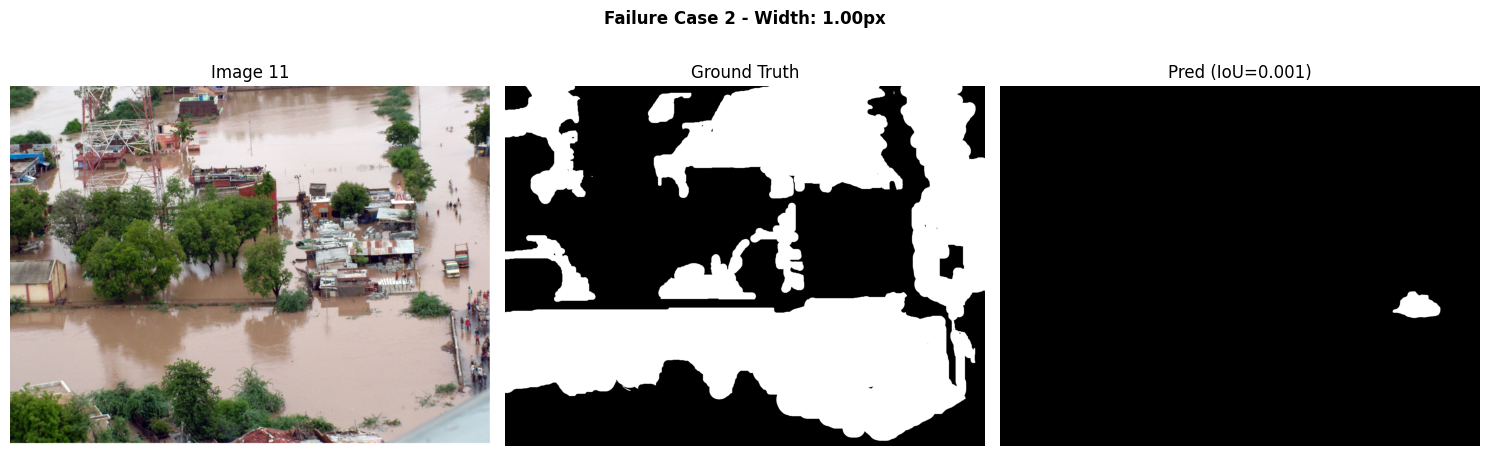

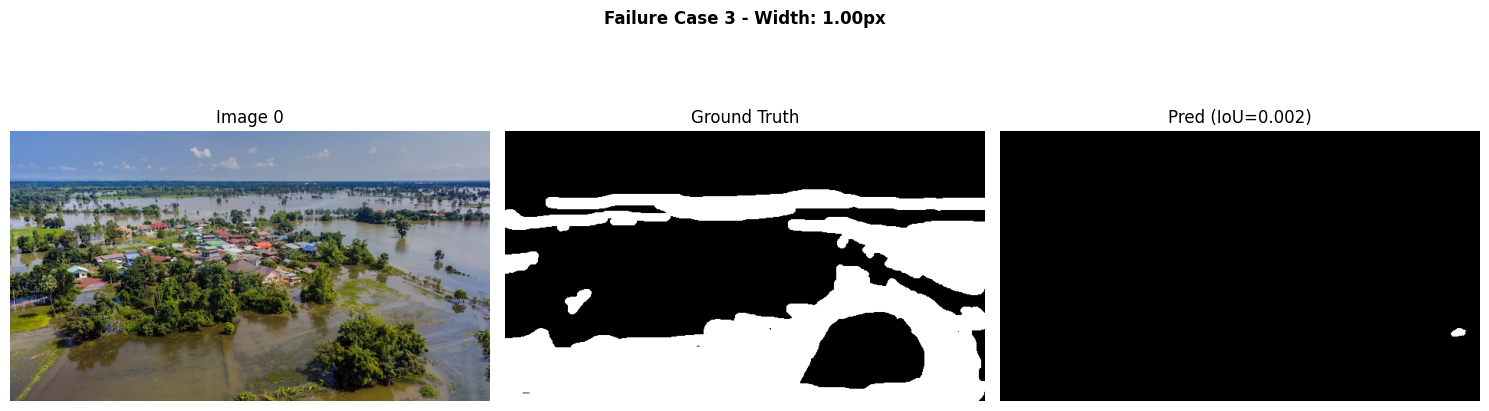


=== ANALYZING FINE-TUNED FAILURES ===
Failure cases: 4

=== FAILURE REDUCTION ===
Pretrained failures: 7
Fine-tuned failures: 4
Reduction: 3 (42.9%)


In [20]:
# ---- 4.4 Análisis de errores (failure cases) ----
def analyze_failure_cases(images, masks, predictor, threshold_iou=0.3):
    failure_cases = []
    for i, (image, mask_gt) in enumerate(zip(images, masks)):
        ys, xs = np.where(mask_gt > 0)
        if len(xs) == 0:
            continue
        point_x = int(xs[len(xs) // 2]); point_y = int(ys[len(ys) // 2])
        pred_mask, _ = predict_with_point_prompt(predictor, image, [[point_x, point_y]], [1])
        iou = calculate_iou(pred_mask, mask_gt)
        if iou < threshold_iou:
            crack_area = mask_gt.sum()
            crack_ratio = crack_area / (mask_gt.shape[0] * mask_gt.shape[1])
            if crack_area > 0:
                crack_length = len(xs)
                avg_width = crack_area / crack_length if crack_length > 0 else 0
            else:
                avg_width = 0
            failure_cases.append({
                'idx': i, 'iou': iou, 'water_area': crack_area, 'water_ratio': crack_ratio,
                'avg_width': avg_width, 'image': image, 'mask_gt': mask_gt, 'pred_mask': pred_mask
            })
    return failure_cases

print("=== ANALYZING PRETRAINED FAILURES ===")
failures_pretrained = analyze_failure_cases(val_images, val_masks, predictor, threshold_iou=0.4)
print(f"Failure cases: {len(failures_pretrained)}")

if len(failures_pretrained) > 0:
    failure_ious = [f['iou'] for f in failures_pretrained]
    failure_widths = [f['avg_width'] for f in failures_pretrained]
    print(f"\nFailure statistics:")
    print(f"  Mean IoU: {np.mean(failure_ious):.3f}")
    print(f"  Mean water region width: {np.mean(failure_widths):.2f} px")

    worst_cases = sorted(failures_pretrained, key=lambda x: x['iou'])[:3]
    for i, case in enumerate(worst_cases):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(case['image']); axes[0].set_title(f"Image {case['idx']}"); axes[0].axis('off')
        axes[1].imshow(case['mask_gt'], cmap='gray'); axes[1].set_title('Ground Truth'); axes[1].axis('off')
        axes[2].imshow(case['pred_mask'], cmap='gray'); axes[2].set_title(f"Pred (IoU={case['iou']:.3f})"); axes[2].axis('off')
        plt.suptitle(f"Failure Case {i+1} - Width: {case['avg_width']:.2f}px", fontweight='bold')
        plt.tight_layout(); plt.show()

print("\n=== ANALYZING FINE-TUNED FAILURES ===")
failures_finetuned = analyze_failure_cases(val_images, val_masks, predictor_finetuned, threshold_iou=0.4)
print(f"Failure cases: {len(failures_finetuned)}")

if len(failures_pretrained) > 0:
    reduction = (1 - len(failures_finetuned)/len(failures_pretrained)) * 100
else:
    reduction = 0.0
print(f"\n=== FAILURE REDUCTION ===")
print(f"Pretrained failures: {len(failures_pretrained)}")
print(f"Fine-tuned failures: {len(failures_finetuned)}")
print(f"Reduction: {len(failures_pretrained) - len(failures_finetuned)} ({reduction:.1f}%)")
